In [8]:
import copy
import sys
import os
import glob
sys.path.append('../..')

from model import processing

asset_ls = ['DOT', 'ETH', 'SOL', 'BTC']
usd_name = 'BUSD'
tick = '1s'

path = 'input/'
extension = 'csv'
os.chdir(path)
os.chdir('..')
price_data = {}
result = []

for prefix in asset_ls:
    os.chdir(path)
    asset_result = glob.glob(prefix + usd_name + '-' + tick + '-' + '*.{}'.format(extension))
    os.chdir('..')
    price_data[prefix] = processing.import_binance_prices(path, asset_result)[::12]


# input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
print(len(price_data['DOT']))
# input_filename = 'input/test.csv'
# output_filename = 'output/' + prefix + usd_name + "-" + tick + "-output.csv"


# input_filename = 'DOT_crash.csv'
# price_data = processing.import_prices(path, input_filename)


# final_price = price_data[-1]
# price_data.extend([final_price] * 100)
price_list = []
for i in range(len(price_data['DOT'])):
    price_dict = {}
    for asset in asset_ls:
        price_dict[asset] = price_data[asset][i].price
    price_list.append(price_dict)

final_prices = price_list[-1]
price_list.extend([copy.deepcopy(final_prices) for i in range(100)])


# we want about .000002 * TVL in volume every block

28778


In [9]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, dynamic_asset_fee, dynamic_lrna_fee, dynamicmult_lrna_fee, dynamicmult_asset_fee, dynamicadd_asset_fee, dynamicadd_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {}
omnipool_assets = ['HDX', 'USD', 'AUSD', 'ETH', 'DOT']

assets = {
    'HDX': {'usd price': 0.005, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.30},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.30},
    'SOL': {'usd price': price_list[0]['SOL'], 'weight': 0.10},
}

lrna_price_usd = 22
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 10},  # , 'fee_lower': 7200},
            lrna_fee=dynamicadd_lrna_fee(
                minimum=0.0005,
                amplification=1/50,
                raise_oracle_name='fee_raise',
                decay=0.000001,
                fee_max=0.1,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=0.0025,
                amplification=1/10,
                raise_oracle_name='fee_raise',
                decay=0.000005,
                fee_max=0.4,
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3,
                # skip_assets=['HDX']
            )
        ),
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=back_and_forth(
                pool_id='omnipool',
                percentage=0.00005
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        ),
        'LPDOT': Agent(
            holdings={'DOT': liquidity['DOT'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPUSD': Agent(
            holdings={'USD': liquidity['USD'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPETH': Agent(
            holdings={'ETH': liquidity['ETH'] / 10},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    # evolve_function=fluctuate_prices(volatility={tkn: 1 for tkn in assets}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # save_data = {
    #     'prices': pu.Datastream(asset='all'),
    #     # 'pool_val': pu.Datastream(pool='omnipool', prop='pool_val'),
    #     'asset_fee': pu.Datastream(pool='omnipool', prop='asset_fee', key='all'),
    #     'lrna_fee': pu.Datastream(pool='omnipool', prop='lrna_fee', key='all'),
    #     'LP returns': pu.Datastream(agent='LP', prop='cash_out')
    # }
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 28877 time steps
Starting simulation...
Execution time: 158.213 seconds.


'HDX'
'BTC'
'ETH'
'DOT'
'SOL'


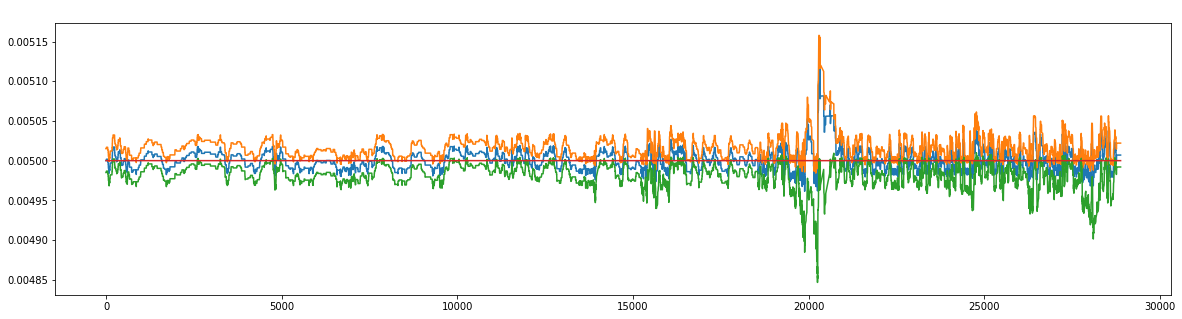

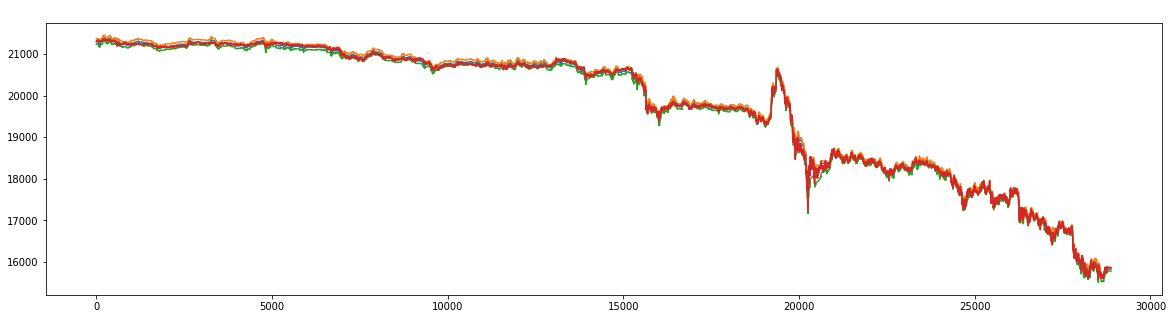

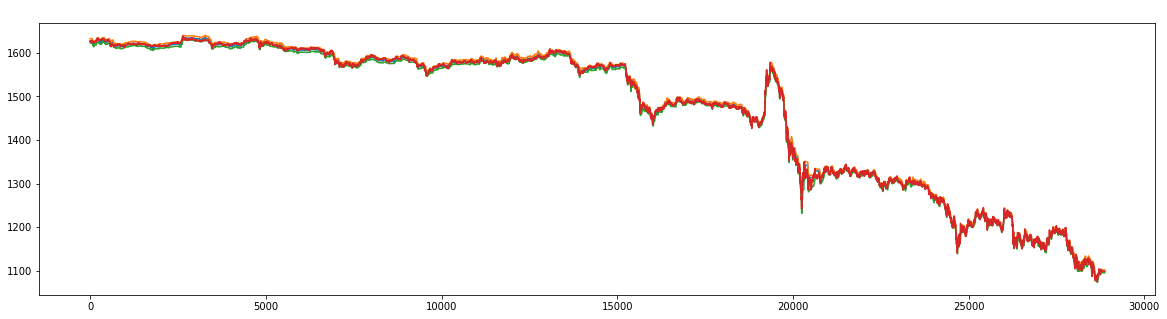

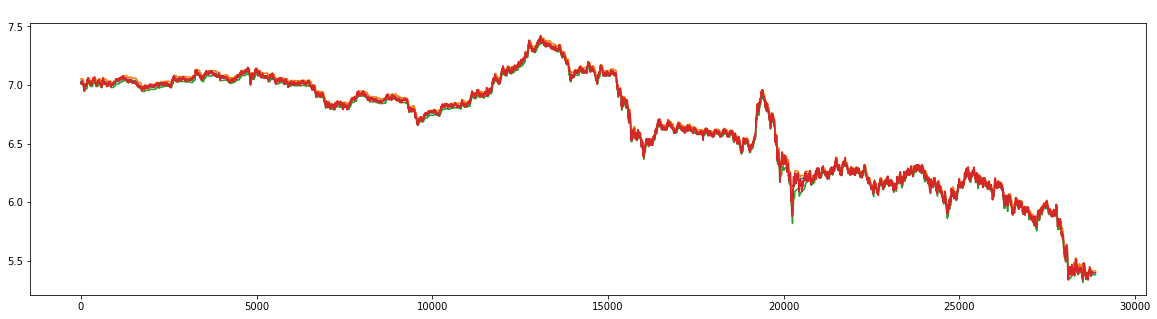

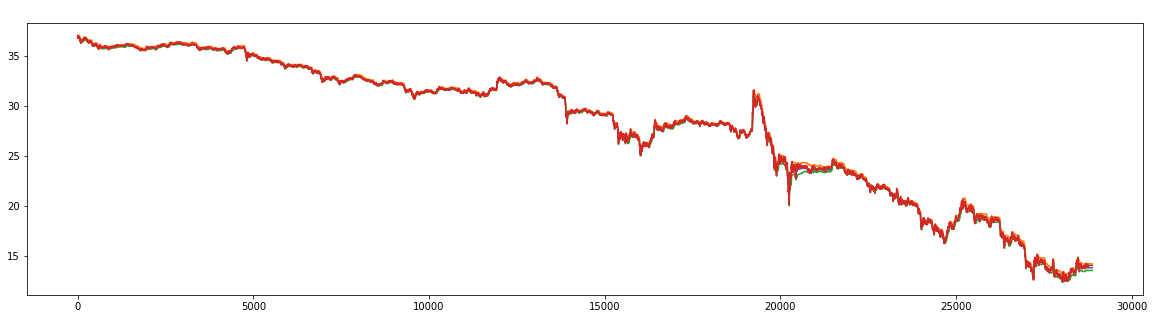

In [10]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events)
USD_lrna_fees = [None]*len(events)
for i in range(len(events)):
    op = events[i]['state'].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    if tkn == 'USD':
        continue
    prices = [None]*len(events)
    last_fees = [None]*len(events)
    last_lrna_fees = [None]*len(events)
    buy_prices = [None]*len(events)
    sell_prices = [None]*len(events)
    market_prices = [None]*len(events)
    for i in range(len(events)):
        op = events[i]['state'].pools['omnipool']
        market_prices[i] = events[i]['state'].external_market[tkn]
        prices[i] = op.usd_price(tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pprint(tkn)
    pu.plot(market_prices, subplot=ax)


In [11]:
market = events[0]['state'].external_market
print(market)

{'HDX': 0.005, 'USD': 1, 'BTC': 21296.04, 'ETH': 1626.28, 'DOT': 7.02, 'SOL': 36.84}


:::FEES:::


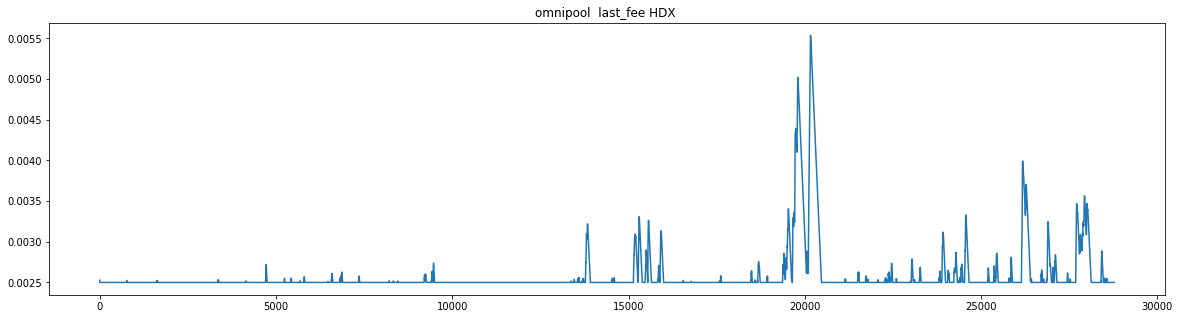

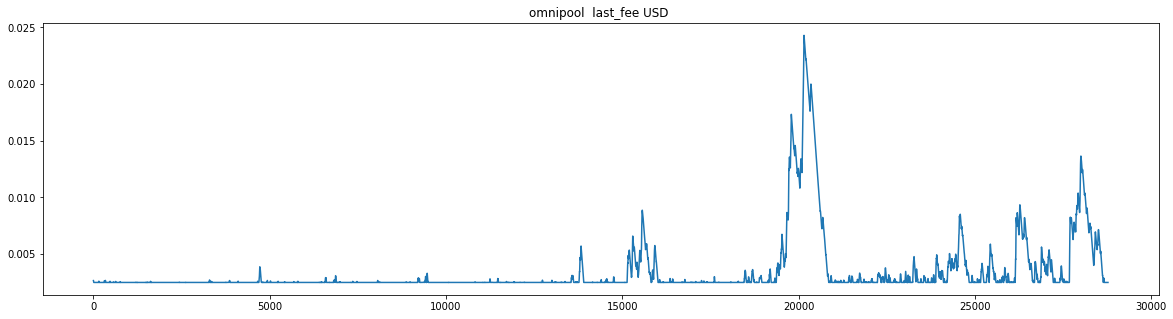

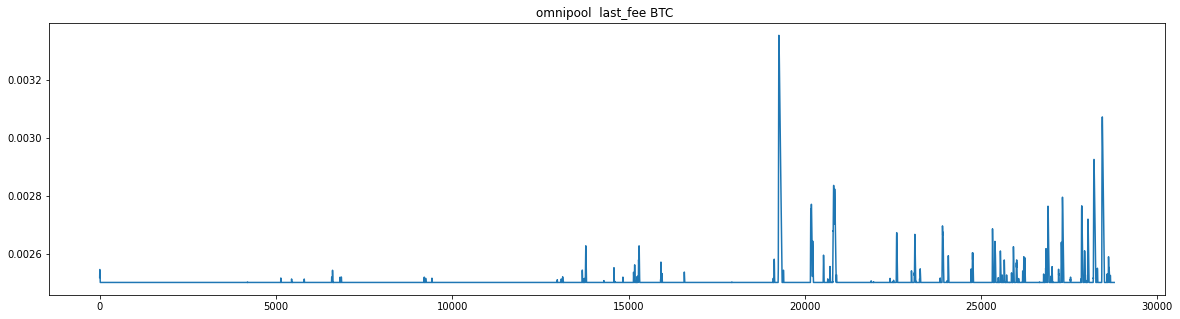

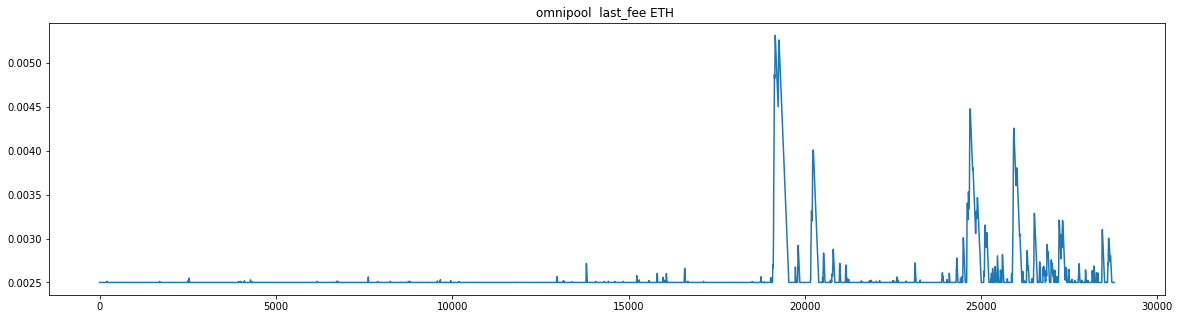

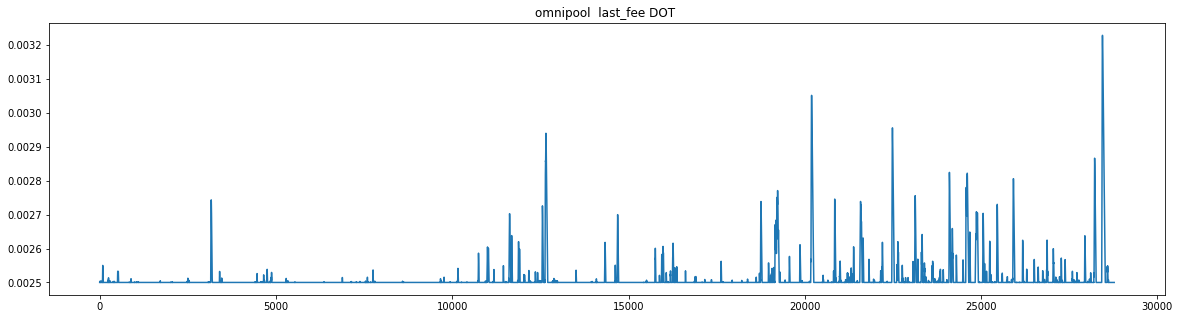

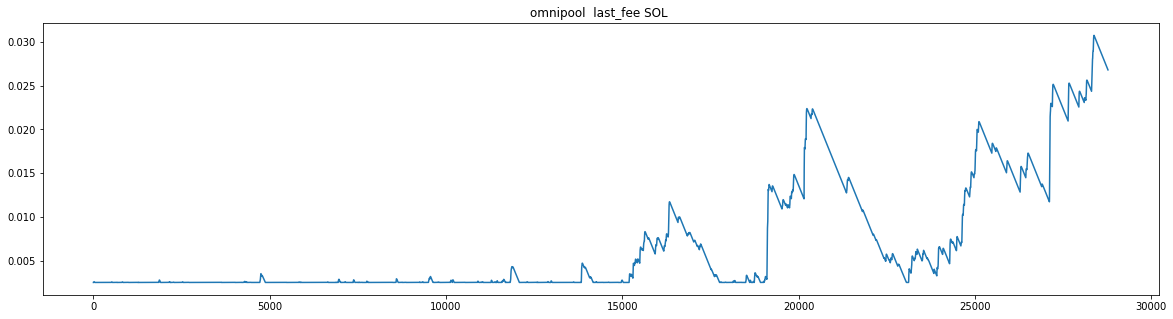

In [12]:
# print(events[0])
# dynamic_mult = [events[i]['state'].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
# asset_fee = pu.get_datastream(events, pool='omnipool', prop='asset_fee', key='all')  # {tkn: [event['asset_fee'][tkn] for event in events[10:]] for tkn in assets}
# lrna_fee = pu.get_datastream(events, pool='omnipool', prop='lrna_fee', key='all')  # {tkn: [event['lrna_fee'][tkn] for event in events[10:]] for tkn in assets}
# print(lrna_fee['HDX'][1])
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    # ax = pu.plot(events[10:], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[100:], pool='omnipool', prop='last_fee', key=tkn)
    # plt.title(tkn)

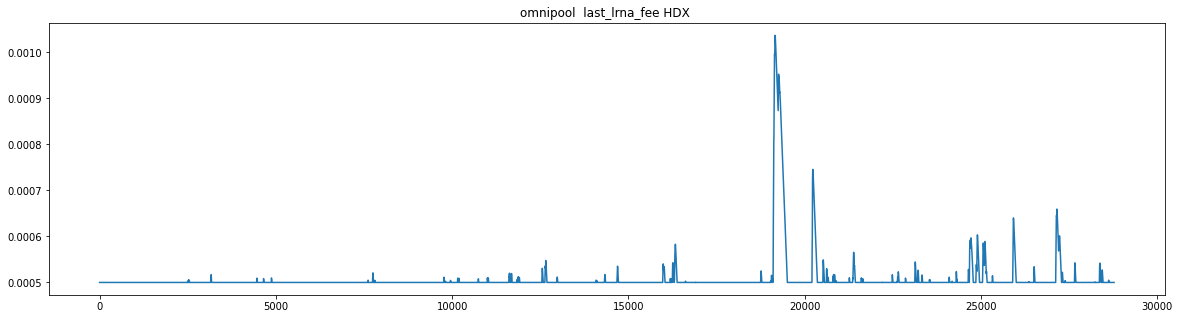

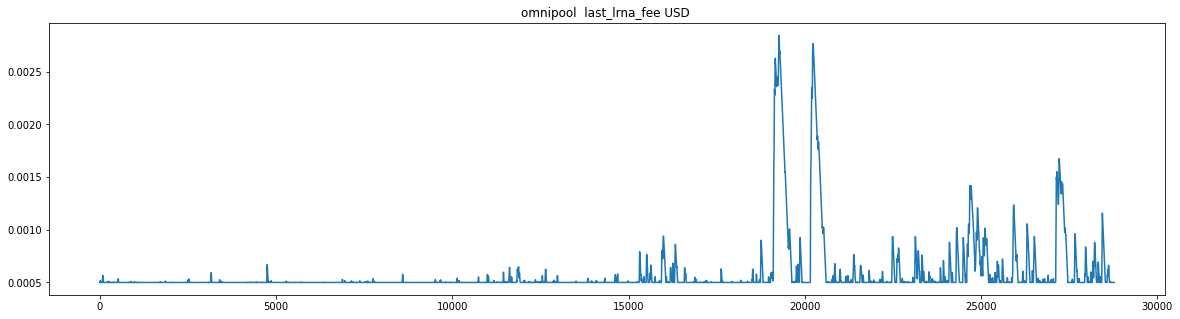

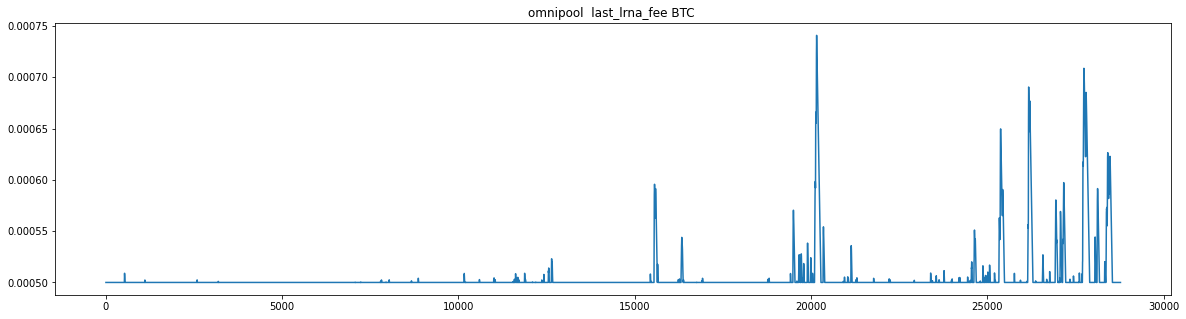

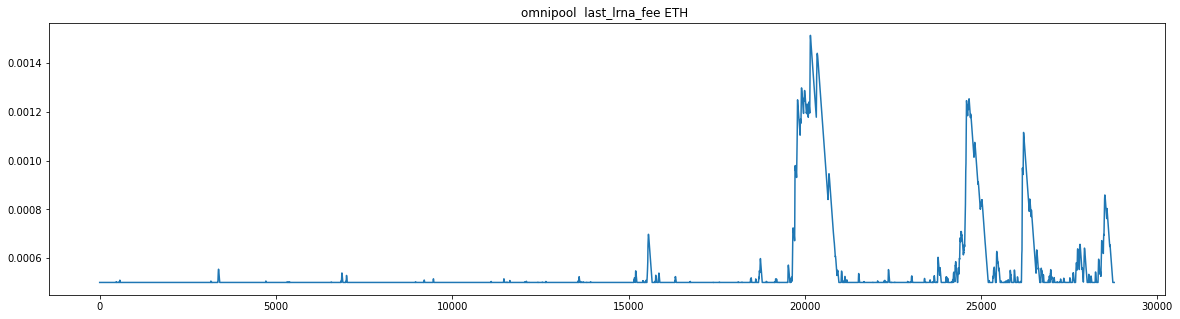

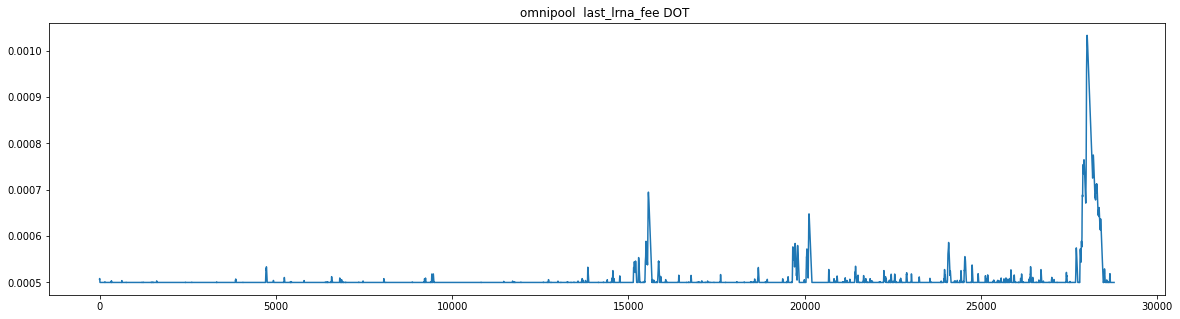

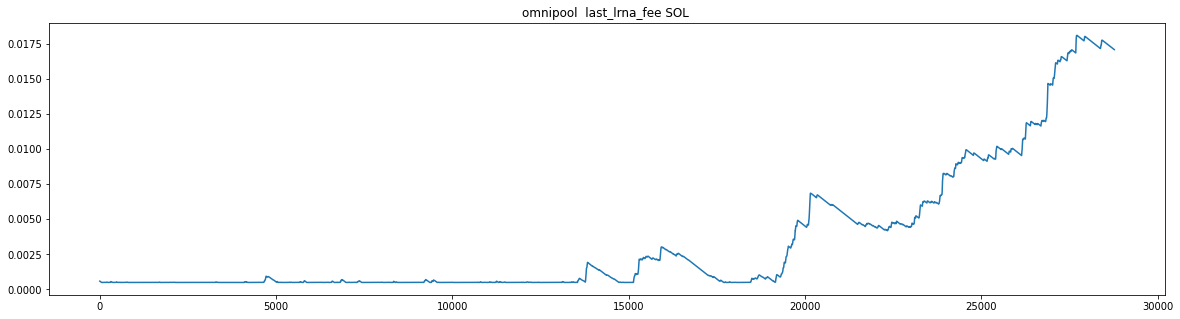

In [13]:
for tkn in initial_state.pools['omnipool'].asset_list:
    pu.plot(events[100:], pool='omnipool', prop='last_lrna_fee', key=tkn)

In [14]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0005
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1]['state'].agents['Arbitrageur']

Starting simulation...
Execution time: 148.166 seconds.


<AxesSubplot:title={'center':'  '}>

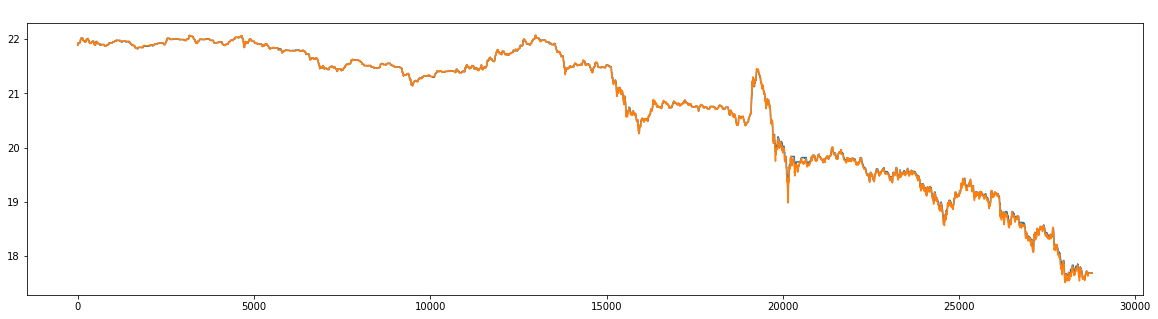

In [15]:
# for tkn in initial_state.pools['omnipool'].asset_list:
#     # print(tkn)
#     # plt.figure(figsize=(20, 5))
#     ax = pu.plot(events[100:], pool='omnipool', prop='price', key=tkn)
#     pu.plot(events2[100:], pool='omnipool', prop='price', key=tkn, subplot=ax)
#     # plt.title(tkn)

lrna_prices = [1/event['state'].pools['omnipool'].price("USD") for event in events[100:]]
lrna_prices2 = [1/event['state'].pools['omnipool'].price("USD") for event in events2[100:]]
ax = pu.plot(lrna_prices)
pu.plot(lrna_prices2, subplot=ax)

'HDX'
'BTC'
'ETH'
'DOT'
'SOL'


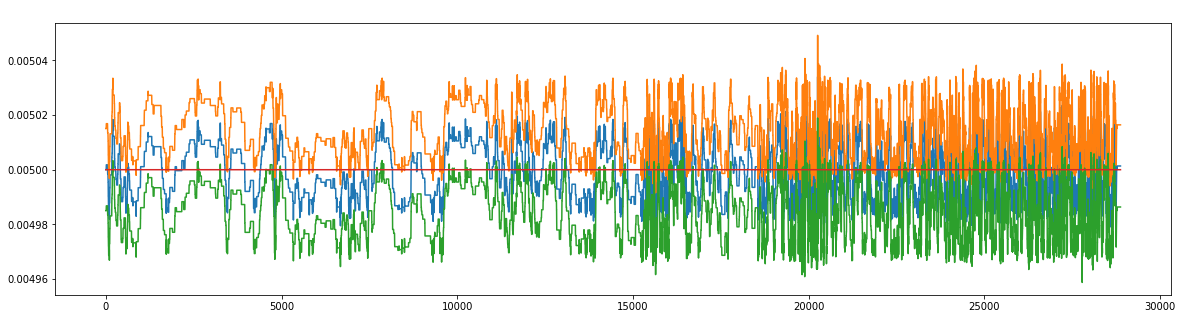

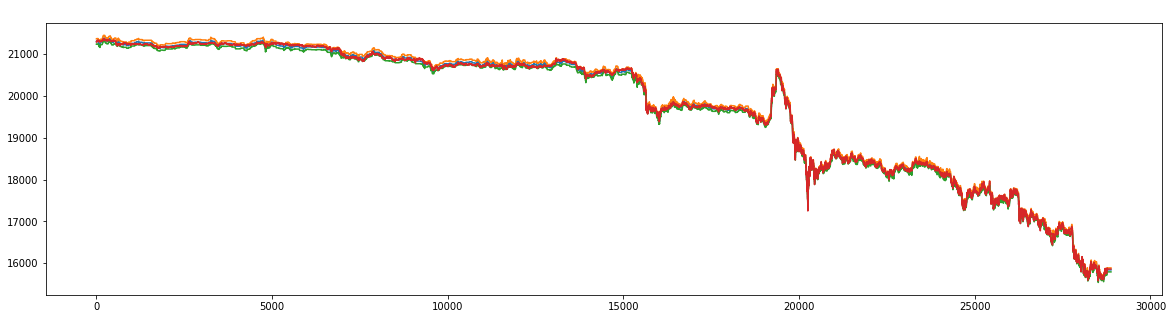

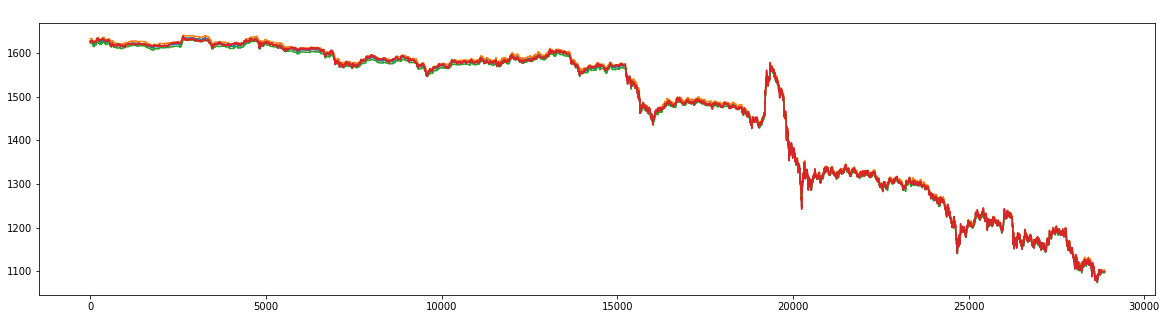

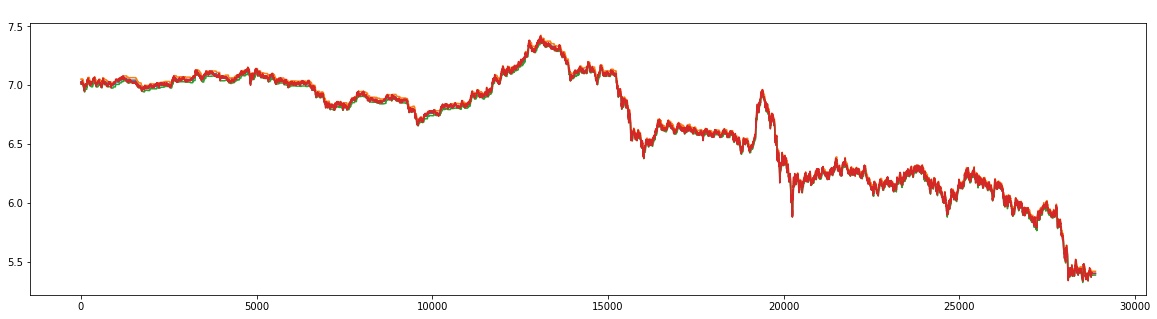

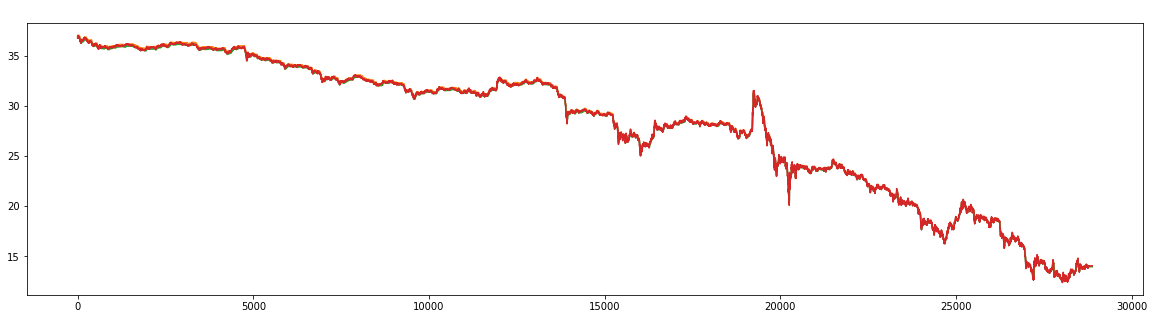

In [16]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events2)
USD_lrna_fees = [None]*len(events2)
for i in range(len(events2)):
    op = events2[i]['state'].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    if tkn == 'USD':
        continue
    prices = [None]*len(events2)
    last_fees = [None]*len(events2)
    last_lrna_fees = [None]*len(events2)
    buy_prices = [None]*len(events2)
    sell_prices = [None]*len(events2)
    market_prices = [None]*len(events2)
    for i in range(len(events2)):
        op = events2[i]['state'].pools['omnipool']
        market_prices[i] = events2[i]['state'].external_market[tkn]
        prices[i] = op.usd_price(tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pprint(tkn)
    pu.plot(market_prices, subplot=ax)


Text(0.5, 1.0, 'LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

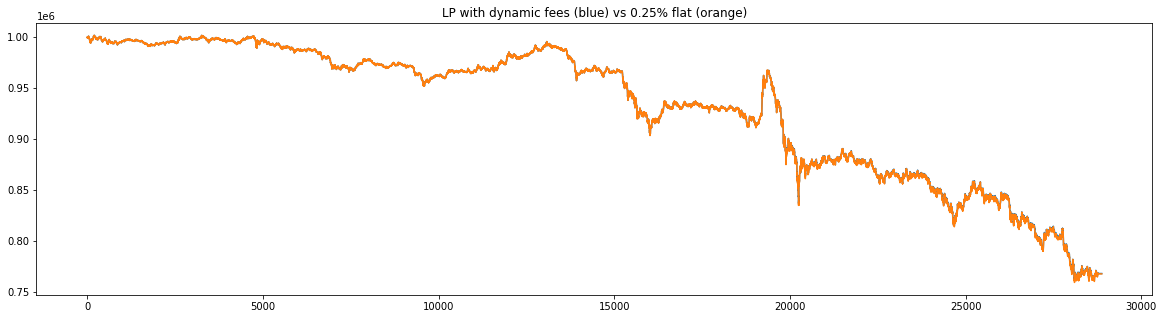

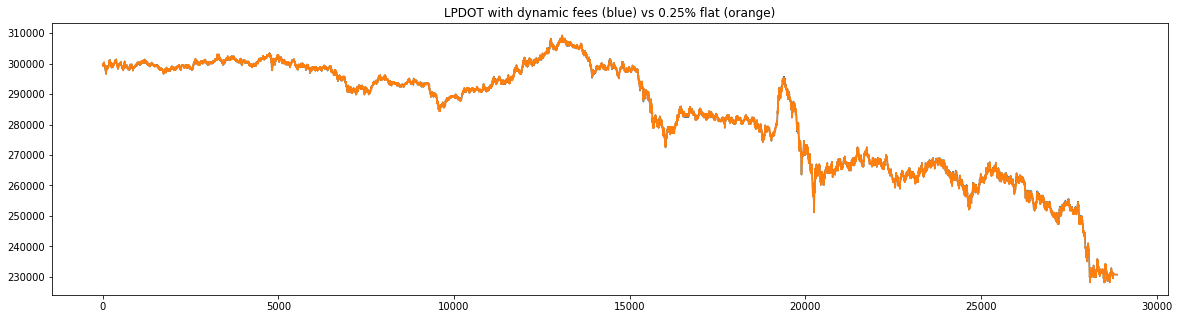

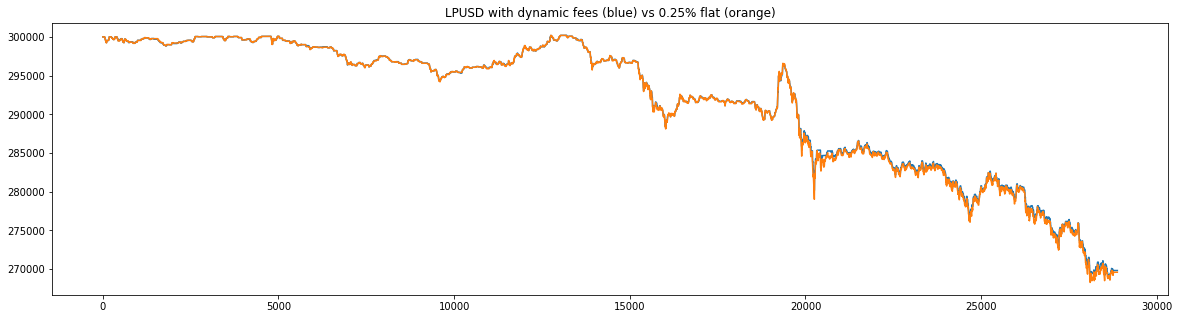

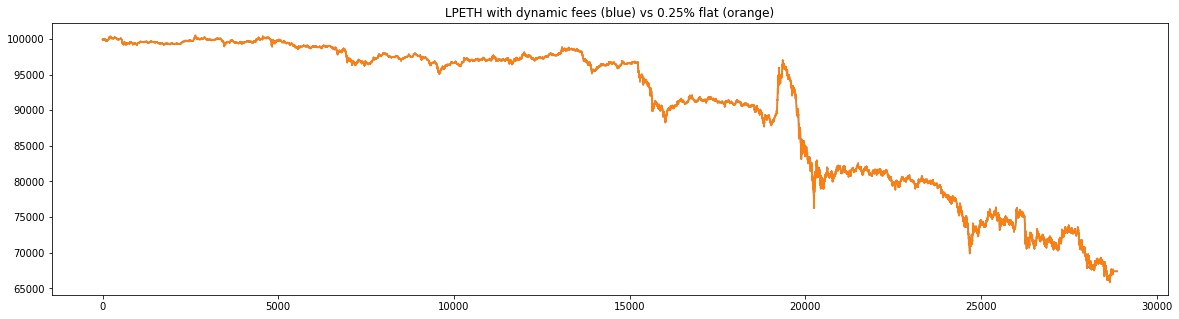

In [17]:
# lp_with_fees = pu.get_datastream(events, 'LP returns')
# lp_no_fees = pu.get_datastream(events2, 'LP returns')
# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()

ax = pu.plot(events, agent='LP', prop='cash_out')
pu.plot(events2, agent='LP', prop='cash_out', subplot=ax)
plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')





ax = pu.plot(events, agent='LPDOT', prop='cash_out')
pu.plot(events2, agent='LPDOT', prop='cash_out', subplot=ax)
plt.title('LPDOT with dynamic fees (blue) vs 0.25% flat (orange)')

# lp_cashout = state.cash_out(state.agents['LPDOT'])

ax = pu.plot(events, agent='LPUSD', prop='cash_out')
pu.plot(events2, agent='LPUSD', prop='cash_out', subplot=ax)
plt.title('LPUSD with dynamic fees (blue) vs 0.25% flat (orange)')

ax = pu.plot(events, agent='LPETH', prop='cash_out')
pu.plot(events2, agent='LPETH', prop='cash_out', subplot=ax)
plt.title('LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

# profiler.disable()
# stats = pstats.Stats(profiler)
# stats.dump_stats('profile-data')



In [18]:
# lp_cashout = state.cash_out(state.agents['LPDOT'])


# lrna_imbalance = [event['state'].pools['omnipool'].lrna_imbalance for event in events]
pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPUSD']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPUSD']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPUSD']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPUSD']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPUSD'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPUSD']))

pprint(events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))
pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']))
pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH']))
savings = events[-1]['state'].cash_out(events[-1]['state'].agents['LPETH']) - events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPETH'])
pprint(savings/events[0]['state'].cash_out(events[0]['state'].agents['LPETH']))

mpf('300000.0000000000000000000000000000000000000000000042')
mpf('269834.34084005156222896396887213518863910588757900429')
mpf('269608.66417431059560371488612417352605049028706337289')
mpf('0.00075225555246988875083027582653887529538533505210464685')
mpf('99938.547760680409906395034715365531021167758288428475')
mpf('67380.099032948434150836655989705889945600843017837983')
mpf('67385.344521434947450334808115994580917458618512410609')
mpf('-0.000052487139387641495267555787016030248442930041617248959')


In [19]:
# pprint(events2[-1]['state'].cash_out(events2[-1]['state'].agents['LPDOT']))
init_omni = events[1]['state'].pools['omnipool']
final_omni = events[-1]['state'].pools['omnipool']
init_omni2 = events2[1]['state'].pools['omnipool']
final_omni2 = events2[-1]['state'].pools['omnipool']

pprint(events[-1]['state'].cash_out(events[-1]['state'].agents['LPDOT']))
pprint(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
pprint(events[-1]['state'].agents['LPDOT'].share_prices[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT'))
print(events[-1]['state'].pools['omnipool'].price('DOT'))
print(events2[-1]['state'].pools['omnipool'].price('DOT'))
print(events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('USD'))
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
print(init_omni.liquidity['DOT'])
print(final_omni.liquidity['DOT'])
print(final_omni2.liquidity['DOT'])
print(init_omni.lrna['DOT'])
print(final_omni.lrna['DOT'])
print(final_omni2.lrna['DOT'])
print(init_omni.lrna_total)
print(final_omni.lrna_total)
print(final_omni2.lrna_total)
pprint(init_omni.lrna)
pprint(final_omni.lrna)
pprint(final_omni2.lrna)

pprint(events[0]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])
pprint(events2[-1]['state'].agents['Arbitrageur'].holdings['LRNA'])


# pprint(events2[0]['state'].agents['LPDOT'])
# pprint(events2[-1]['state'].agents['LPDOT'])
# pprint(events[0]['state'].agents['LPDOT'])
# pprint(events[-1]['state'].agents['LPDOT'])
# state.cash_out(state.agents['LPDOT'])


mpf('230719.00081135427586650995381290272778591996068909933')
mpf('42674.250001347101950213114426750467500016668336151233')
mpf('0.3195454305896326047392730035801400412103788257461426')
0.31954543058963260473927300358014004121037882574614
0.30517914281650902717379505584253467656917110831153
0.30555082836761272316979198735560600581572937504218
0.045454542046889413534748899872411945996542740901869
0.056533091413880466545281774977935037134060461001345
0.056547709347801827708025896187806098959529414949843
7.0300000000000006069797867288192637315185069891493
5.3982390699684777959916162818555733263465307325293
5.4034165466950141580709557736088472024452364395431
512091.1087897169681730117709502372957043953203163
524776.79187606989331054822878357134714682421250895
524495.46274032079269161010492634211979919293726917
163636.36159177000117400190111119130822292564454093
160150.93151473656819065959302974731544476182490586
160260.02311535937254070731168596927262428868028916
531818.1760251665352437861

In [20]:
# print(events[0], events[1000])

In [21]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LP']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LP']))

999330.04878099547510724054737998728765689456126203
768041.79485307238717902517093110053238640159251514
767692.04697289179015291083840597652040827021601049


In [22]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPDOT']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPDOT']))

299573.25746799426604088131374127228321482441946756
230719.0008113542758665099538129027277859199606891
230738.88177413714832243718261052919717136941621708


In [23]:
print(processing.cash_out(events[0]['state'], events[-1]['state'].agents['LPUSD']))
print(processing.cash_out(events[-1]['state'], events[-1]['state'].agents['LPUSD']))
print(processing.cash_out(events2[-1]['state'], events2[-1]['state'].agents['LPUSD']))

300000.0
269834.340840051562228963968872135188639105887579
269608.66417431059560371488612417352605049028706337


In [24]:
print(events[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events2[-1]['state'].agents['LPDOT'].holdings[('omnipool', 'DOT')])
print(events[0]['state'].pools['omnipool'].price('DOT')/events[0]['state'].pools['omnipool'].price('USD'))
print(events[-1]['state'].pools['omnipool'].price('DOT')/events[-1]['state'].pools['omnipool'].price('USD'))
print(events2[-1]['state'].pools['omnipool'].price('DOT')/events2[-1]['state'].pools['omnipool'].price('USD'))
# print(events[-1]['state'].agents['LPAUSD'])

42674.250001347101950213114426750467500016668336151
42674.250001347101950213114426750467500016668336151
7.0300000000000006069797867288192637315185069891493
5.3982390699684777959916162818555733263465307325293
5.4034165466950141580709557736088472024452364395431


<AxesSubplot:title={'center':'omnipool  price USD '}>

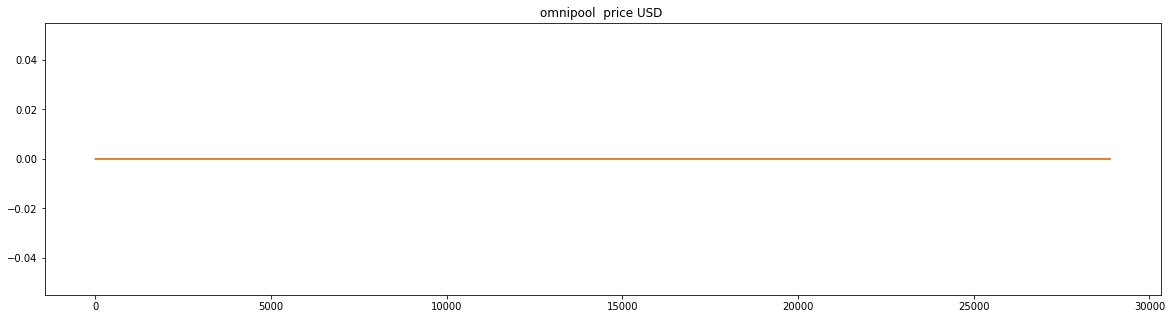

In [25]:
ax = pu.plot(events, pool='omnipool', prop='price', key='USD')
pu.plot(events2, pool='omnipool', prop='price', key='USD', subplot=ax)

In [26]:
final_pool1 = events[-1]['state'].pools['omnipool']
final_pool2 = events2[-1]['state'].pools['omnipool']
lrna_price1 = 1/events[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price1)
lrna_price2 = 1/events2[-1]['state'].pools['omnipool'].price('USD')
print(lrna_price2)
total_lrna1 = sum(events[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna1)
total_lrna2 = sum(events2[-1]['state'].pools['omnipool'].lrna[tkn] for tkn in events2[-1]['state'].pools['omnipool'].asset_list)
print(total_lrna2)
print(lrna_price1*total_lrna1)
print(lrna_price2*total_lrna2)
print(final_pool1.lrna_imbalance) # dynamic fees cause us to burn a lot more LRNA!
print(final_pool2.lrna_imbalance)

17.688754939632963868534118442190922417268536693765
17.684182286667158861825249102344650461579067344674
531818.17602517241617546518210224762578653212580115
531818.17602517107145224779417755979681180743507776
9407201.3881518616550039751241503781574183920555606
9404769.5681919673609104138484129498876939457692919
0.0
0.0


In [27]:
print(initial_state)

global state 
pools: 

    Omnipool: omnipool
    ********************************
    tvl cap: inf
    lrna fee:
    
        HDX: Dynamic LRNA fee (oracle=fee_raise, amplification=0.02, min=0.0005)
        USD: Dynamic LRNA fee (oracle=fee_raise, amplification=0.02, min=0.0005)
        BTC: Dynamic LRNA fee (oracle=fee_raise, amplification=0.02, min=0.0005)
        ETH: Dynamic LRNA fee (oracle=fee_raise, amplification=0.02, min=0.0005)
        DOT: Dynamic LRNA fee (oracle=fee_raise, amplification=0.02, min=0.0005)
        SOL: Dynamic LRNA fee (oracle=fee_raise, amplification=0.02, min=0.0005)
    
    asset fee:
    
        HDX: Dynamic fee (oracle=fee_raise, amplification=0.1, min=0.0025)
        USD: Dynamic fee (oracle=fee_raise, amplification=0.1, min=0.0025)
        BTC: Dynamic fee (oracle=fee_raise, amplification=0.1, min=0.0025)
        ETH: Dynamic fee (oracle=fee_raise, amplification=0.1, min=0.0025)
        DOT: Dynamic fee (oracle=fee_raise, amplification=0.1, min=0.0

In [28]:
pprint(events[0]['state'].pools['omnipool'].liquidity)
pprint(events[0]['state'].agents['Trader'].holdings)
pprint(events[-1]['state'].agents['Trader'].holdings)

{'BTC': mpf('51.642905061963903515587662618525574795932874016967334'),
 'DOT': mpf('512091.07039904907878322080820860344042684526225305481'),
 'ETH': mpf('737.4269179049939595708172682119853688132970101901234'),
 'HDX': mpf('220000014.99368768897833139855027090141715930074933925'),
 'SOL': mpf('29810.300134646030622625809512767912802856859460514078'),
 'USD': mpf('3600000.224905315334674970978254063521257389511247786')}
{'AUSD': 1000000000,
 'BTC': mpf('999999999.99999648037483146143467828104061365869511726'),
 'DOT': mpf('999999999.96800777875751423164158998054394815473774635'),
 'ETH': mpf('999999999.99995393021579267755730241478012076495006035'),
 'HDX': mpf('999999985.00631231102166860144972909858284069925066147'),
 'LRNA': mpf('1000000000.0'),
 'R1': 1000000000,
 'R2': 3000000000,
 'SOL': mpf('999999999.99796833500149345086666223037058337360928945'),
 'USD': mpf('999999999.77509468466532502902174593647874261048875241')}
{'AUSD': 1000000000,
 'BTC': mpf('999999999.88664689072411117